# Red completa de Bogotá

Ya habiendo creado el archivo csv base para la realizacion de este trabajo, el siguiente paso es volver a crear las redes que ya habian sido creadas, pero en este caso, solo para los municipios de Bogotá y Soacha (Suachintown), hacer el respectivo estudio de la distribucuin de grado en la red no dirigida, el in_degree y out_degree de la red dirigida sin pesar, y la fuerza de cada nodo para el caso de la red pesada, con el numero de viajes en cada sentido (recordar que es el numero de viajes y no de personas como tal), se haran los respectivos ajustes a curvas exponenciales (dados los resultados del primer estudio) y se hara el estudio de clusterización y de ser necesario de cliques. En resumen, los estudios preeliminares de redes complejas. Se haran redes dependieno particularmente del estrato, medio de transporte y otros parametros que lo requieran y me diga Hurtado. 

In [51]:
# Importacion de las librerias necesarias 
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import operator
import itertools
from scipy.optimize import curve_fit

Se importa el archivo *Viajes_en_Bogota.csv* 

In [3]:
great_df = pd.read_csv('Viajes_en_Bogota.csv')
great_df

,Unnamed: 0,id_hogar,Estado,Utam,Sector,Seccion,Manzana,p5_fecha,p7_Barrio_vivienda,Latitud,...,p7_id_actividad_economica,p7v_lugar_inicio_dia,p8v_barrio_vereda,p9v_id_municipio,p9v_municipio,p10v_hora_salida,p11v_condujo_vehiculo,p13v_condujo_bicicleta,p15v_subsidio_SITP,Sexo
0,7089,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,6.0,1.0,NaN,NaN,NaN,05:20:00,2.0,2.0,4.0,Hombre
1,7090,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,6.0,1.0,NaN,NaN,NaN,05:20:00,2.0,2.0,4.0,Hombre
2,7091,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,NaN,1.0,NaN,NaN,NaN,14:00:00,2.0,2.0,4.0,Mujer
3,7092,17081,2,UTAM9,8534,3,14,2019-05-21,MIRADOR,4.761663,...,NaN,1.0,NaN,NaN,NaN,14:00:00,2.0,2.0,4.0,Mujer
4,7096,P07096,1,UTAM9,8534,3,14,2019-05-21,MIRADOR DEL NORTE,4.761913,...,NaN,1.0,NaN,NaN,NaN,06:30:00,2.0,2.0,4.0,Mujer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105471,40322,P02949,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,NaN,1.0,NaN,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer
105472,40323,P02949,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,NaN,1.0,NaN,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer
105473,40324,P02949,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,NaN,1.0,NaN,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer
105474,40333,P02950,1,UTAM570,20,5,8,2019-04-11,LA MARIA SOACHA,4.597883,...,19.0,1.0,NaN,NaN,NaN,08:00:00,2.0,9.0,4.0,Mujer


Se separan las columnas zat_origen y zat_destino para poder hacer la red de movilidad 

In [4]:
df_red_adj = (great_df[['zat_origen','zat_destino']]
                    .sort_values(by = ['zat_origen','zat_destino'])
                    .dropna()
                    .reset_index())
df_red_adj['viajes'] = 1
df_red_adj = df_red_adj.drop(columns  = ['index'])
df_red_adj

,zat_origen,zat_destino,viajes
0,0.0,0.0,1
1,0.0,60.0,1
2,0.0,66.0,1
3,0.0,85.0,1
4,0.0,93.0,1
...,...,...,...
105471,1141.0,225.0,1
105472,1141.0,247.0,1
105473,1141.0,252.0,1
105474,1141.0,477.0,1


Hay un error a la hora de transformar las matrices de adyasencia en redes a partir de NetworkX, no existen las columnas 1061 y 959, lo sual quiere decir que nadie va hacia 1061 y 959, pero de la misma manera, no existen las filas 308 y 478, es decir, nadie sale de 308 y 478,por lo cual toca crear dichas filas y columnas para que la matriz se mantenga simetrica, pero para mantener la dirección, estas filas y columnas se llenaran de ceros. 

En el primer notebook la zona 959 presentaba problemas pero no la 1061, seguramente sea que alguien de otro municipio fuera de bogota llegaba a dicha zona, pero por el filtrado ya esa coneccion no existe.

In [5]:
# Creacion de la matriz de adyacencia pesada 
matrix_w = (df_red_adj.groupby(['zat_origen', 'zat_destino'], as_index = False)['viajes']
                     .agg('sum')
                     .pivot_table(values = ('viajes'), index = 'zat_origen', columns = 'zat_destino')
                     .fillna(0))
matrix_w[959] = 0
matrix_w[1061] = 0
matrix_w.loc[308] = 0
matrix_w.loc[478] = 0

In [6]:
# Creacion de la matriz de adyacencia sin pesar
matrix_unw = (df_red_adj.drop_duplicates()
                     .pivot_table(values = ('viajes'), index = 'zat_origen', columns = 'zat_destino')
                     .fillna(0))
matrix_unw[959] = 0
matrix_unw[1061] = 0
matrix_unw.loc[308] = 0
matrix_unw.loc[478] = 0

In [6]:
np.unique(great_df['mun_destino'].values)

array([11001., 25754.])

Ya con las matrices de adyacencia corregidas de manera satisfactoria, manteniendo la matriz cuadrada (como debe ser), ya se proceden a crear las redes pertinentes para empezar el analisis del problema, las cuales son, red simple sin pesar, red dirigida sin pesar, red pesada no dirigida y red pesada dirigida.

In [7]:
# Creacion de los grafos
und_unw_graph = nx.from_pandas_adjacency(matrix_unw)
d_unw_graph = nx.from_pandas_adjacency(matrix_unw, create_using = nx.DiGraph)
und_w_graph = nx.from_pandas_adjacency(matrix_w)
d_w_graph = nx.from_pandas_adjacency(matrix_w, create_using = nx.DiGraph)

## Una pequeña muestra del grafo de movilidad del conjunto Bogota Soacha no dirigido sin pesar


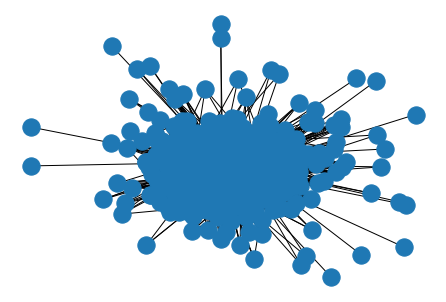

In [47]:
nx.draw(und_unw_graph)

In [8]:
# Se define la funcion de distribucion del grado
def degree_dist(G):
    degree = dict(G.degree())
    values_x = sorted(set(degree.values()))
    dist_y = [list(degree.values()).count(x) for x in values_x]
    return values_x, dist_y
def in_out_degree(G):
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    in_x = sorted(set(in_degree.values()))
    out_x = sorted(set(out_degree.values()))
    in_y = [list(in_degree.values()).count(x) for x in in_x]
    out_y = [list(out_degree.values()).count(x) for x in out_x]
    return in_x, in_y, out_x, out_y
def mean_degree(G):
    degree = dict(G.degree())
    array = []
    for i in degree.values():
        array.append(i)
    array = np.asarray(array)
    return np.sum(array)/len(array)

### Grado y analisis de la red
En esta sección se analisan las principales cantidades del grafo simple, y tambien la distribución del grado, la cual es aporximadamente exponencial (a ojo).

In [16]:
x, y = degree_dist(und_unw_graph)

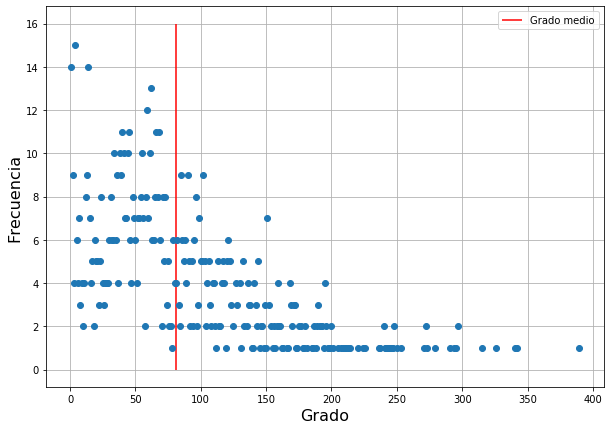

In [67]:
plt.figure(figsize = (10,7))
plt.plot(x, y, 'o')
plt.vlines(mean_degree(und_unw_graph), 0, 16, color = 'r',label = 'Grado medio')
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [14]:
mean_degree(und_unw_graph)

81.30965593784684

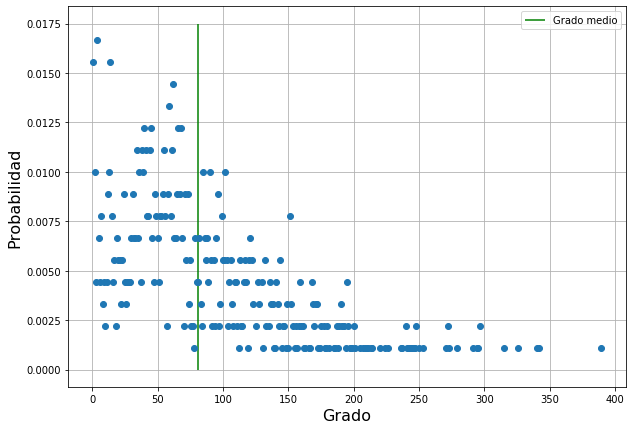

In [49]:
y_array = np.asarray(y)/sum(y)
plt.figure(figsize = (10,7))
plt.plot(x, y_array, 'o')
plt.vlines(mean_degree(und_unw_graph), 0, 0.0175, color = '',label = 'Grado medio')
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Probabilidad', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [16]:
print(und_unw_graph.number_of_edges())
print(len(und_unw_graph))

36630
901


In [14]:
2*und_unw_graph.number_of_edges()/(len(und_unw_graph)*(len(und_unw_graph)-1))

0.09034406215316315

In [17]:
2*und_unw_graph.number_of_edges()/len(und_unw_graph)

81.30965593784684

In [20]:
nx.diameter(und_unw_graph)

4

Lo primero que toca hacer es describir la red. La red cuenta con un numero de nodos $n = 901$, los cuales cuentan con un total de $36630$ conecciones. El grafo cuenta con una densidad $\Delta = 0.09034406215316315$ la cual es baja, es decir que la red no esta muy conectada, lo cual tambien se puede ver en el valor del grado medio de $k_{mean} = 81.31$ es mas de diez veces menor al numero de nodos presentes en la red, se puede decir que en una primera aproximacion, cada nodo solo se conecta con un decimo del total de nodos en la red. Por otra parte, el diametro de la red (como lo supuse), es de $4$, pero este valor no es muy relevante ya que lo mas probable es que nadie viaje entre los dos lugares que esten separados por cuatro conecciones, sas zonas deben ser algo como un potrero en Suachintown y otro en Torca.

Depronto si el grafo se hiciera con zonificaciones mas grandes como UTAMS, este estaria mas interconectado.

Como se puede ver en las dos graficas, tanto de frecuencia como de probabilidad, paraciera ser (de una manera demasiado aproximada e intuitiva, por ahora no muy rigurosa) que estas siguen una ley exponencial. Claramente, para poder concluir esto se debe tener cierto tratamiento de los datos, pero de llegar a ser cierto, esto significaria que en esta curiosa situacion, hay alguna cantidad que se conserva en el sistema, la cuestion es, ¿cual?.

In [65]:
# Zonas con mayor grado 
degree_dict = dict(und_unw_graph.degree())
sorted_d = dict( sorted(degree_dict.items(), key=operator.itemgetter(1),reverse=True))
dict_degree = dict(itertools.islice(sorted_d.items(), 10))
dict_degree

{276.0: 389,
 322.0: 342,
 275.0: 340,
 299.0: 326,
 354.0: 315,
 454.0: 297,
 997.0: 297,
 167.0: 295,
 456.0: 294,
 255.0: 291}

Aca se pueden ver cuales son las zonas (ZAT) con mayor grado en la ciudad. Dado que aun no se esta trabajando con la red pesada, no se puede decir que son las zonas a las que mas viaja la gente, lo que si se puede decir es que estan zonas que se conectan con mas zonas en la ciudad por medio de, a lo sumo, un viaje, es decir, personas de toda la ciudad viajan a estos lugares.

| Zat | Zona            | Grado |
|-----|-----------------|-------|
| 276 | Marly           | 389   |
| 322 | Salitre         | 342   |
| 275 | Hippies         | 340   |
| 299 | Jardin botanico | 326   |
| 354 | U Tadeo         | 315   |
| 454 | ASAB            | 297   |
| 997 | Fiscalia        | 297   |
| 167 | La Castellana   | 295   |
| 456 | Museo del oro   | 294   |
| 255 | Lourdes         | 291   |

Aca se pueden ver particularmente tres grupos en especifico que se conecten por medio de viajes con el resto de la ciudad, y estos son __Chapinero central__, __Salitre__ y __El centro__, junto con la castellana. Todo el pentagono entre la calle 65, calle 45, carreras 7 y avenida caracas presentan un grado altisimo. Al igual que la zona del centro comprendida por la calle 26, Jimenez, carrera 3 y 7, junto con la zona que rodea la carrera 13 por la plaza de san victorino. La zona salitre esta comprendida por la avenida La Esperanza desde el bunquer hasta la avenida Rojas, cruza la 26 e incluye el area del Jardin botanico. 

Algo que se puede resaltar es la importancia de la carrera 13 como eje de "simetria" para una de estas agrupaciones, con suma importancia tambien en la zona __Centro__.

Uno puede hacerse la imagen de que estas tres zonas estan organizadas por los ejes dados por dos grandes avenidas, la 26 y la caracas.

### Grado in y out de la red dirigida

In [38]:
x_in, y_in, x_out, y_out = in_out_degree(d_unw_graph)

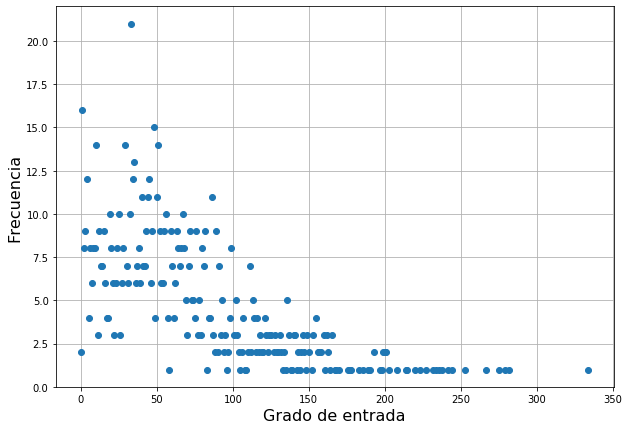

In [66]:
plt.figure(figsize = (10,7))
plt.plot(x_in, y_in, 'o')
#plt.plot(x_out, y_out, 'p')
#plt.vlines(mean_degree(und_unw_graph), 0, 16, color = 'r',label = 'Grado medio')
plt.xlabel('Grado de entrada', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
#plt.legend()
plt.grid()
plt.show()

Parece ser que el grado de entrada se comporta aun mejor como ley exponencial.

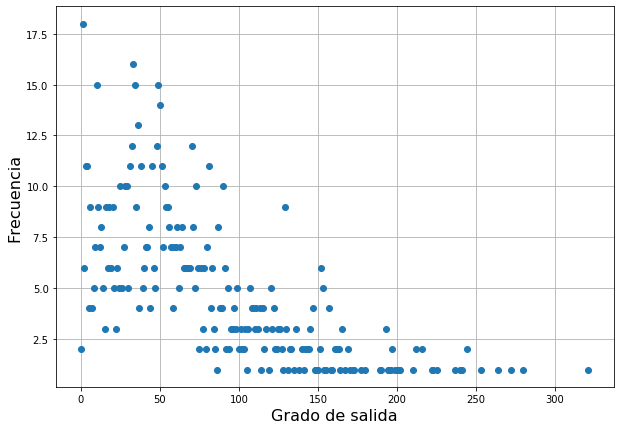

In [64]:
plt.figure(figsize = (10,7))
plt.plot(x_out, y_out, 'o')
#plt.plot(x_out, y_out, 'p')
#plt.vlines(mean_degree(und_unw_graph), 0, 16, color = 'r',label = 'Grado medio')
plt.xlabel('Grado de salida', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
#plt.legend()
plt.grid()
plt.show()

Ya el grado de salida se comporta mas raro, incluso parece no comportarse como una ley de potencias, lo cual es interesante pero me puede joder la vida.

Lo que se realizo a continuacion es un mero intento por ver algun tipo de correlacin entre las frecuencias de entrada y de salida, por mero desparche, pero esto seguramente debe hacerse con mucho mas cuidado. 

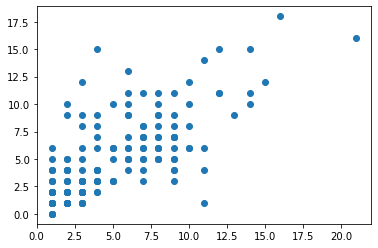

In [42]:
y_exp = y_out+[0,0,0,0]
plt.plot(y_in, y_exp, 'o')
plt.show()

El siguiente paso a realizar es el de ver de donde salen y hacia donde van mas personas, lo cual seguramente sera muy parecido al caso del grafo sin pesar, pero podemos llevarnos varias sorpresas.

In [66]:
# Zonas con mayor grado 
degree_dict_in = dict(d_unw_graph.in_degree())
degree_dict_out = dict(d_unw_graph.out_degree())
sorted_in = dict( sorted(degree_dict_in.items(), key=operator.itemgetter(1),reverse=True))
sorted_out = dict( sorted(degree_dict_out.items(), key=operator.itemgetter(1),reverse=True))

dict_in = dict(itertools.islice(sorted_in.items(), 10))
dict_out = dict(itertools.islice(sorted_out.items(), 10))

print(dict_in, '\t', dict_out, '\t', dict_degree)

{276.0: 334, 322.0: 282, 275.0: 279, 299.0: 275, 354.0: 267, 997.0: 253, 167.0: 244, 255.0: 242, 454.0: 238, 456.0: 236} 	 {276.0: 321, 322.0: 280, 275.0: 272, 354.0: 264, 299.0: 253, 255.0: 244, 456.0: 244, 167.0: 241, 997.0: 240, 454.0: 237} 	 {276.0: 389, 322.0: 342, 275.0: 340, 299.0: 326, 354.0: 315, 454.0: 297, 997.0: 297, 167.0: 295, 456.0: 294, 255.0: 291}


In [71]:
for i in dict_out.keys():
    #if i in dict_degree.keys():
    print(i)

276.0
322.0
275.0
354.0
299.0
255.0
456.0
167.0
997.0
454.0


Como se puede ver en los anteriores codigos, tanto para el grado de entrada como el de salida, el conjunto el mismo conjunto se preserva.

### Clusterizacion

Aca se va a calcular la distribucion para el indice de clusterizacion en la red simple sin pesar.

In [74]:
def cluster_dist(G):
    cluster = nx.clustering(G).values()
    cluster_x = sorted(set(cluster))
    cluster_y = [list(cluster).count(x) for x in cluster_x]
    #hist = [list(bog.values()).count(x) for x in values]
    return cluster_x, cluster_y

In [75]:
clust_x, clust_y = cluster_dist(und_unw_graph)

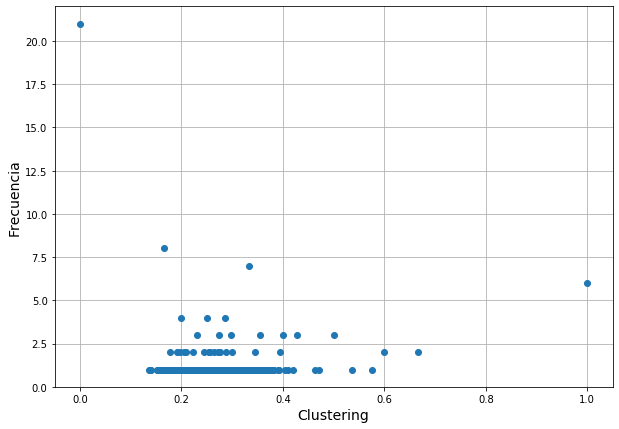

In [77]:
plt.figure(figsize = (10,7))
plt.plot(clust_x, clust_y, 'o')
plt.xlabel('Clustering', fontsize = 14)
plt.ylabel('Frecuencia', fontsize = 14)
plt.grid()
plt.show()

In [91]:
nx.average_clustering(und_unw_graph)

0.26208088454731154

Como se puede notar, el clustering promedio de toda la red es de $0.262$, lo cual significa que en promedio, si dos zonas estan conectadas y uno de estos esta conectado a otro, hay mas o menos una probabilidad de 0.26 de que los  otros dos esten conectados.

Como se puede ver en la grafica de fecuencia de clustering, hay com unos seis nodos en los cuales el clustering es 1, lo cual muestra una subestructura totalmente conectada, posteriormente se verificara cuales zonas componen esa estructura interna.

## Proximamente

El proximo paso a seguir puede ser hacer el analizis de fuerza en los grafos pesados, y como que eso me tocara hacerlo a mano o buscar mejor, al mismo tiempo puedo ir preparando los algoritmos para medir la congestion, midiendo en primera aproximacion, la cantidad de viajes que se estan haciendo en un determinado intervalo de tiempo, para eso deberia separar un df exclusivo con tiempos de viaje, por otra parte, tambien se puede calcular la entropia del grado en cada una de estos casos.

En el trabajo de hoy ya se verifico que efectivamente und_w_graph si es una red pesada, lo que toca hacer es extraer la informacion de la fuerza de cada nodo, hacer la distribucion  aislar los diez nodos mas fuertes.

In [82]:
print(dict(itertools.islice(dict(und_w_graph.degree()).items(), 20)))
print(dict(itertools.islice(dict(und_unw_graph.degree()).items(), 20)))

{0: 175, 1: 7, 2: 2, 3: 4, 4: 40, 932.0: 159, 790.0: 2, 763.0: 4, 737.0: 7, 714.0: 52, 692.0: 48, 674.0: 59, 656.0: 71, 640.0: 64, 627.0: 44, 614.0: 100, 601.0: 49, 588.0: 187, 575.0: 111, 562.0: 88}
{0: 175, 1: 7, 2: 2, 3: 4, 4: 40, 932.0: 159, 790.0: 2, 763.0: 4, 737.0: 7, 714.0: 52, 692.0: 48, 674.0: 59, 656.0: 71, 640.0: 64, 627.0: 44, 614.0: 100, 601.0: 49, 588.0: 187, 575.0: 111, 562.0: 88}


In [ ]:
print(und_unw_graph.edges(data = True))